In [2]:
import os
import sys
import json
import itertools
import yaml
import pandas as pd
from sqlalchemy.engine.url import URL

In [3]:
from src.utils.general import get_db_conn, get_boto3_session
from src.utils import project_constants as constants

In [4]:
from triage.component.audition import Auditioner
from triage.component.audition.pre_audition import PreAudition
from triage import create_engine

In [5]:
cred_file = '../conf/local/credentials.yaml'

#### db connection 

In [6]:
with open(cred_file) as f:
    db_config = yaml.load(f)['db']

db_url = URL(
    'postgres',
    host=db_config['host'],
    username=db_config['user'],
    database=db_config['db'],
    password=db_config['pass'],
    port=db_config['port'],
)

db_con = create_engine(db_url)

/home/kasun/.pyenv/versions/aclu/lib/python3.7/site-packages/ipykernel_launcher.py:2: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  


In [7]:
# experiment_hash = 'dc52ec9e21af7cceb2abd22e876040dd'
experiment_hash = '170870efbfa049eff695a0423dfe5ea8'

### Preaudition

In [8]:
pre_aud = PreAudition(db_con)

model_groups = pre_aud.get_model_groups_from_experiment(experiment_hash)
end_times = pre_aud.get_train_end_times(after='2011-01-01')

In [9]:
# model_groups

In [10]:
len(end_times)

28

In [11]:
# print(model_groups)

#### Model groups

In [12]:
q = """
    select distinct(model_group_id) from triage_metadata.models where built_by_experiment='{exp_hash}'
""".format(
    exp_hash=experiment_hash
)
df = pd.read_sql(q, db_con)
model_groups = df['model_group_id'].tolist()

#### Train end times

In [13]:
q = """
    select distinct(train_end_time) from triage_metadata.models where built_by_experiment='{exp_hash}' order by train_end_time
""".format(
    exp_hash=experiment_hash
)
df = pd.read_sql(q, db_con)
train_end_times =  df['train_end_time'].tolist()

In [14]:
len(train_end_times)

28

#### Initial Metric filters

In [15]:
metric_filters = [
    {
    'metric': 'precision@',
    'parameter': '10_pct',
    'max_from_best': 1,
    'threshold_value': 0.0
    },
    {
    'metric': 'precision@',
    'parameter': '20_pct',
    'max_from_best': 1,
    'threshold_value': 0.0
    },
    {
    'metric': 'precision@',
    'parameter': '30_pct',
    'max_from_best': 1,
    'threshold_value': 0.0
    }
]

# metric_filters = [{
#     'metric': 'precision@',
#     'parameter': param,
#     'max_from_best': 0.4,
#     'threshold_value': 0.3
# }]

In [16]:
aud = Auditioner(
    db_engine=db_con,
    model_group_ids=model_groups,
    train_end_times=train_end_times,
    initial_metric_filters=metric_filters,
    models_table='models',
    distance_table='best_dist_long_term'
)

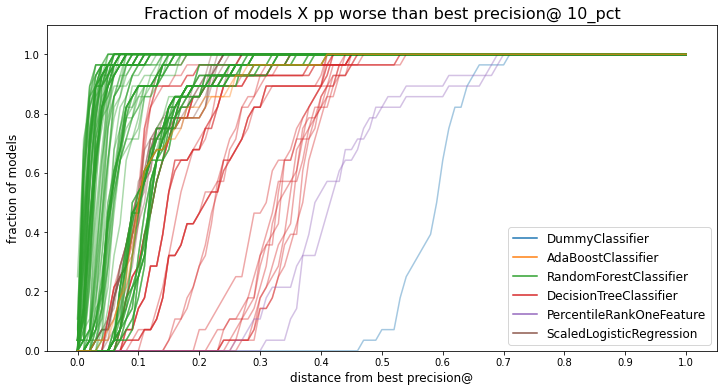

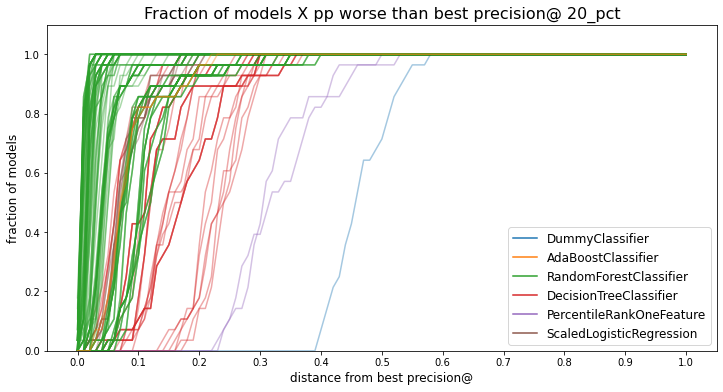

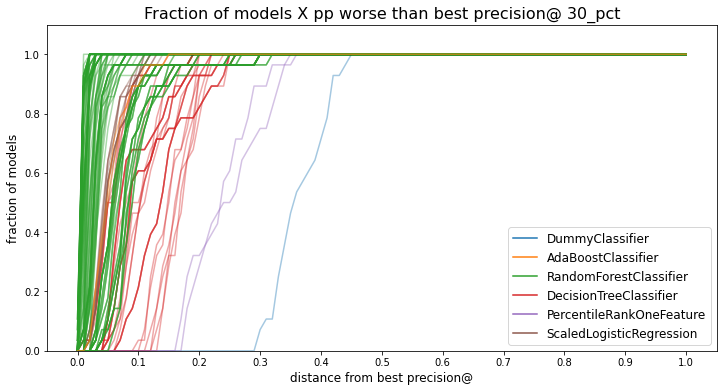

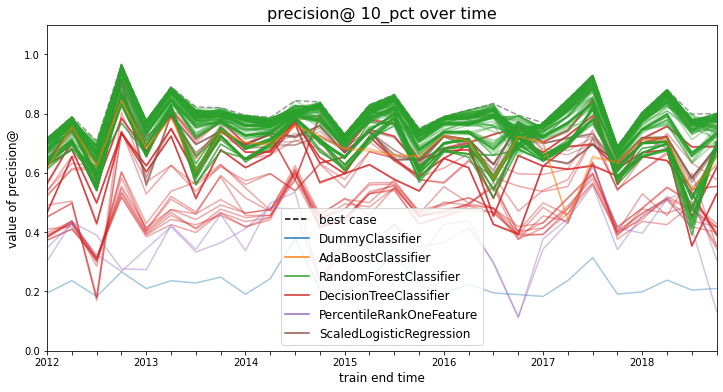

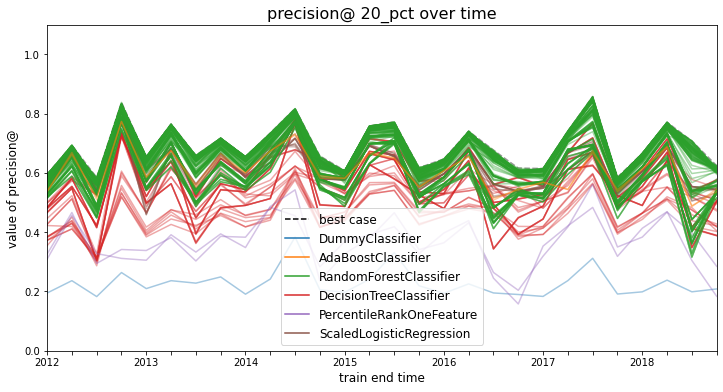

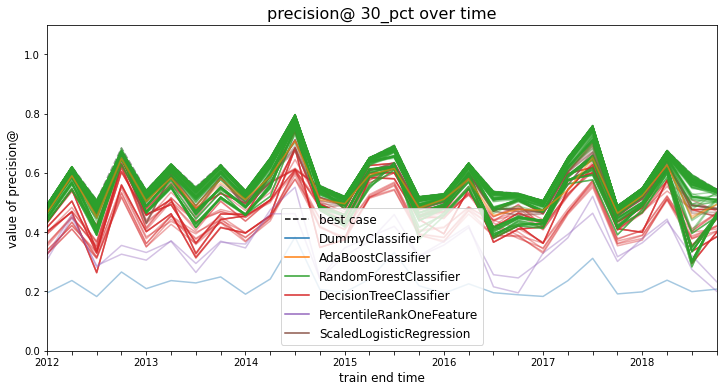

In [17]:
%matplotlib inline
aud.plot_model_groups()

In [18]:
ids = aud.thresholded_model_group_ids

In [19]:
len(ids)

169

#### Tightening thresholds

In [20]:
metric_filters = [
    {
    'metric': 'precision@',
    'parameter': '10_pct',
    'max_from_best': 0.5,
    'threshold_value': 0.6
    },
    {
    'metric': 'precision@',
    'parameter': '20_pct',
    'max_from_best': 0.3,
    'threshold_value': 0.5
    },
    {
    'metric': 'precision@',
    'parameter': '30_pct',
    'max_from_best': 0.2,
    'threshold_value': 0.3
    }
]

In [21]:
aud = Auditioner(
    db_engine=db_con,
    model_group_ids=model_groups,
    train_end_times=train_end_times,
    initial_metric_filters=metric_filters,
    models_table='models',
    distance_table='best_dist_long_term'
)

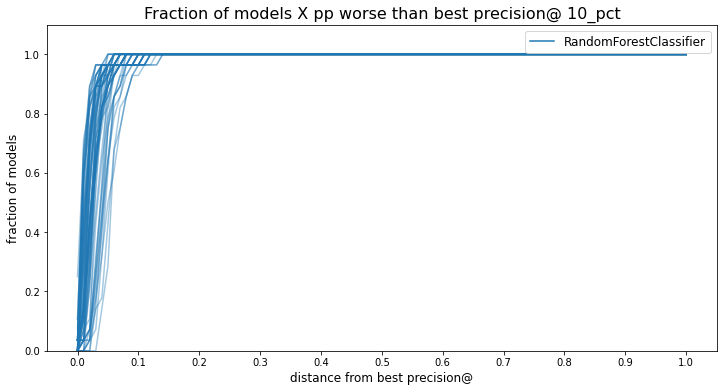

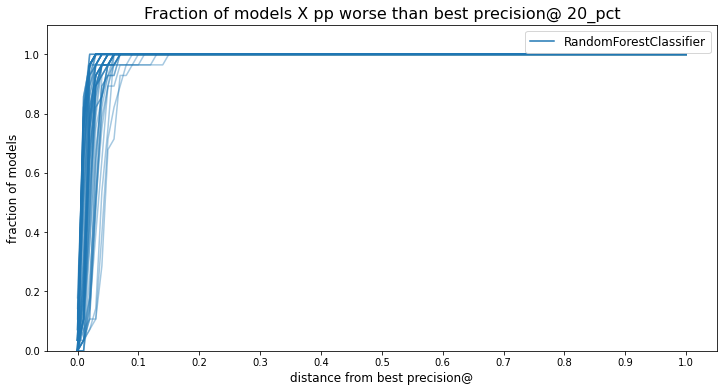

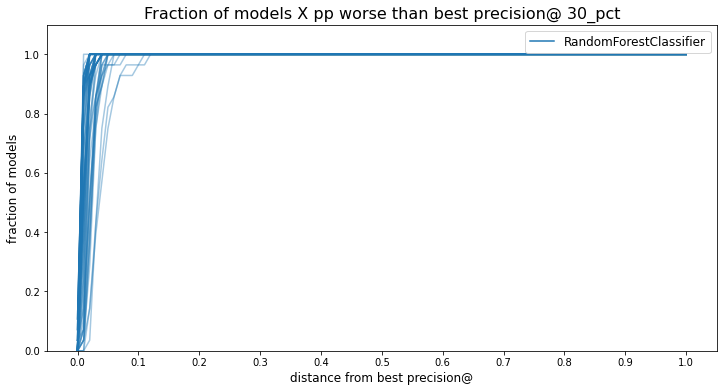

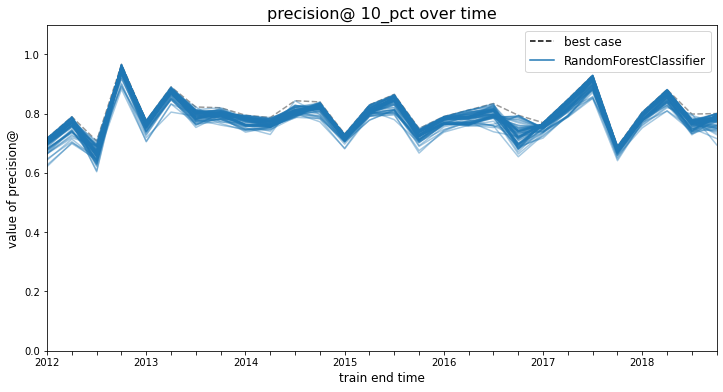

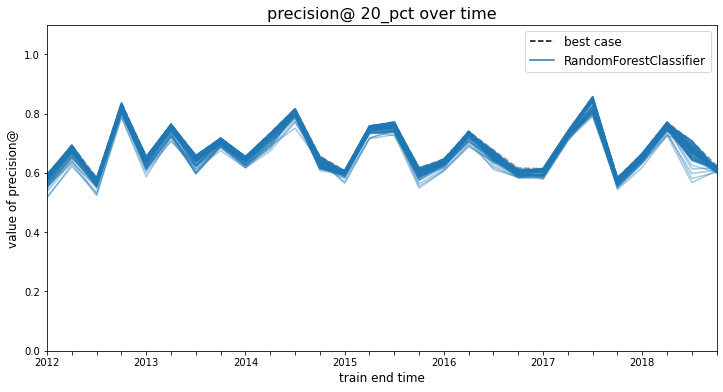

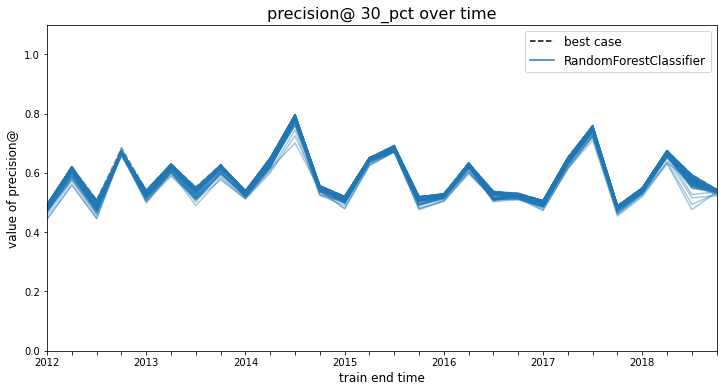

In [22]:
%matplotlib inline
aud.plot_model_groups()

In [23]:
ids = aud.thresholded_model_group_ids
len(ids)

71

#### Rules Maker

In [24]:
from triage.component.audition.rules_maker import (
    SimpleRuleMaker, RandomGroupRuleMaker, create_selection_grid
)

In [25]:
rule1 =  SimpleRuleMaker()
rule1.add_rule_best_current_value(metric='precision@', parameter='10_pct', n=3)
rule1.add_rule_best_average_value(metric='precision@', parameter='10_pct', n=3)
# rule1.add_rule_lowest_metric_variance(metric='precision@', parameter=param, n=3)
rule1.add_rule_most_frequent_best_dist(metric='precision@', parameter='10_pct', n=3)
# rule1.add_rule_best_avg_var_penalized(metric='precision@', parameter=param, n=3)
rule1.add_rule_best_avg_recency_weight(metric='precision@', parameter='10_pct', n=3, decay_type='exponential')


rule2 = RandomGroupRuleMaker(n=1)

rules = create_selection_grid(rule1, rule2)

/home/kasun/.pyenv/versions/aclu/lib/python3.7/site-packages/triage/component/audition/selection_rules.py:203: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  "int"


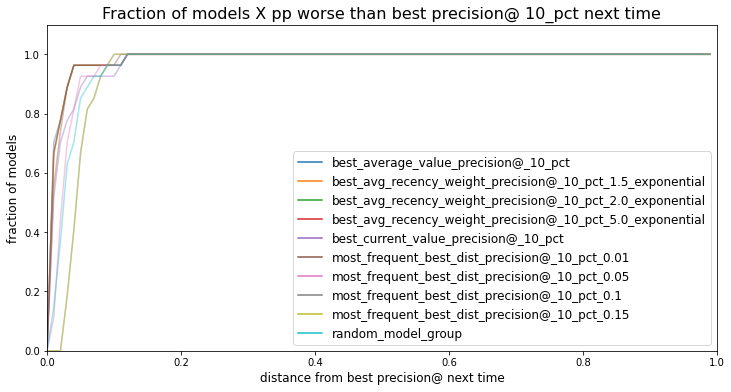

/home/kasun/.pyenv/versions/aclu/lib/python3.7/site-packages/triage/component/audition/selection_rules.py:203: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  "int"


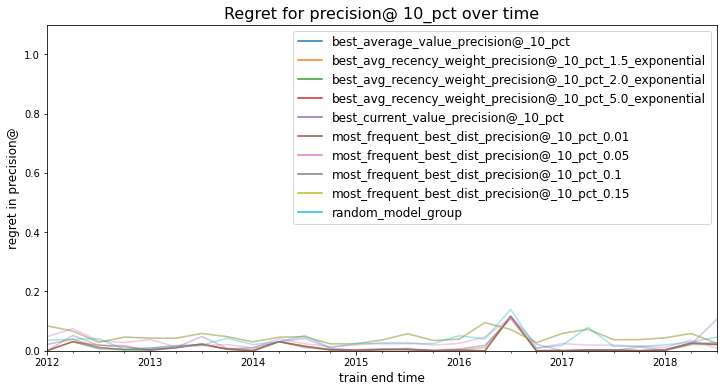

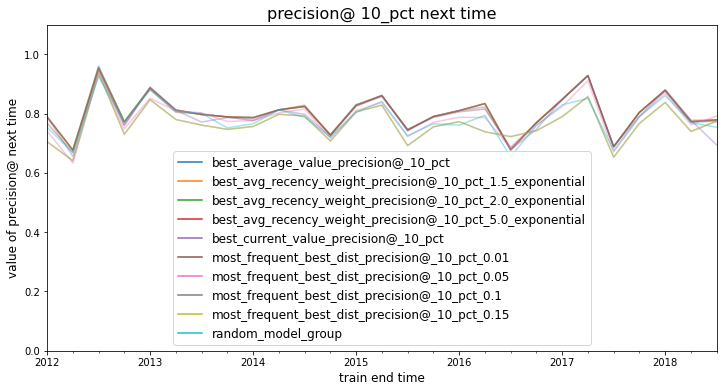

/home/kasun/.pyenv/versions/aclu/lib/python3.7/site-packages/triage/component/audition/selection_rules.py:203: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  "int"


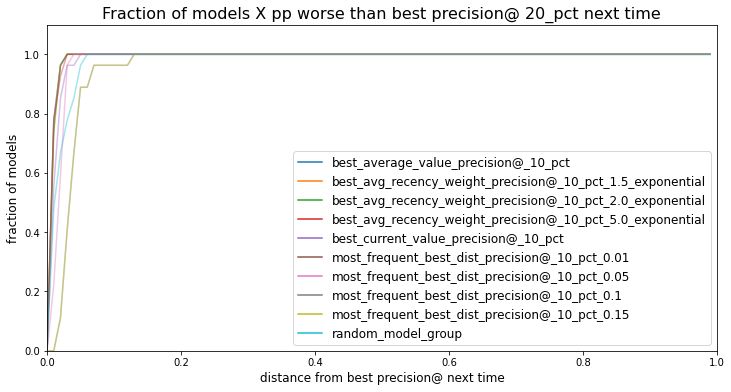

/home/kasun/.pyenv/versions/aclu/lib/python3.7/site-packages/triage/component/audition/selection_rules.py:203: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  "int"


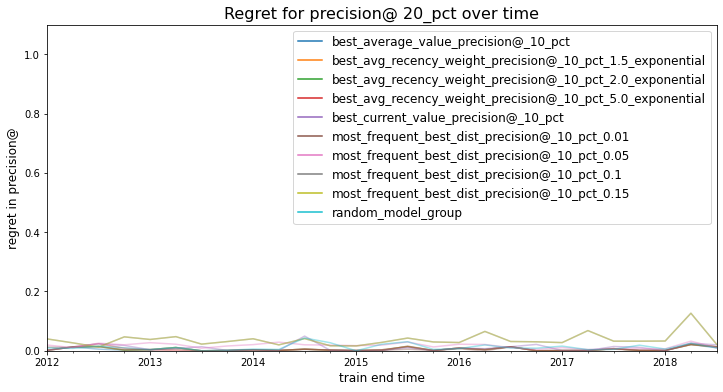

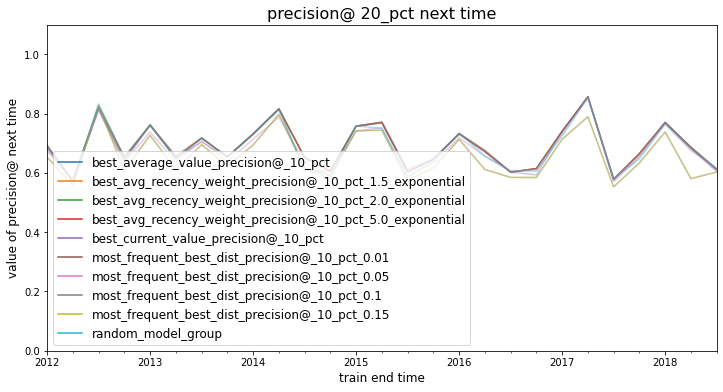

/home/kasun/.pyenv/versions/aclu/lib/python3.7/site-packages/triage/component/audition/selection_rules.py:203: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  "int"


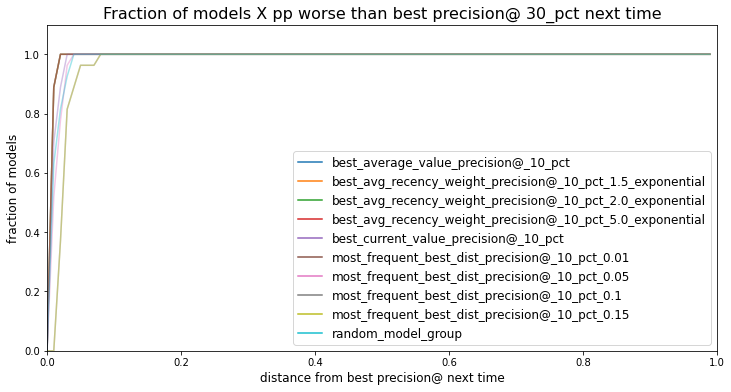

/home/kasun/.pyenv/versions/aclu/lib/python3.7/site-packages/triage/component/audition/selection_rules.py:203: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  "int"


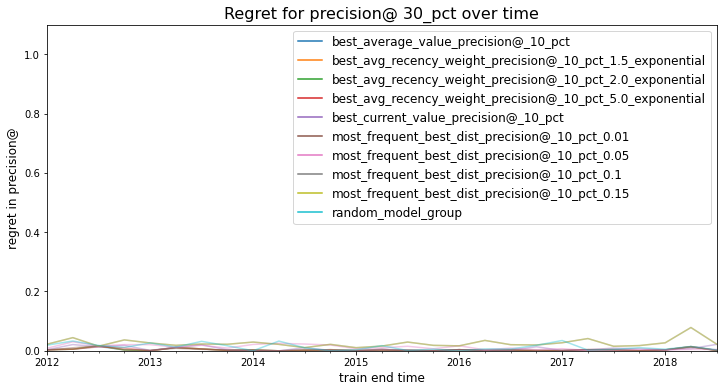

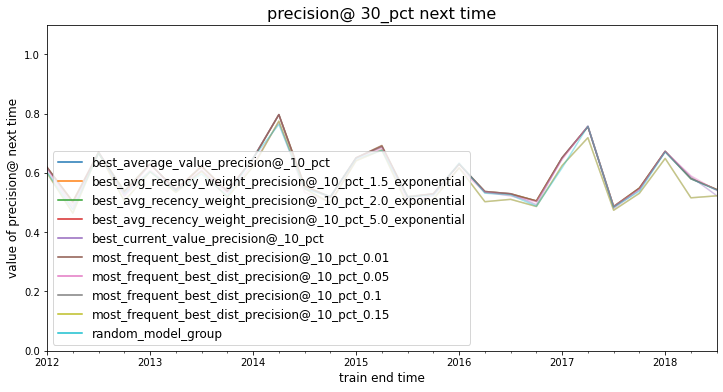

In [26]:
aud.register_selection_rule_grid(rules, plot=True)

In [27]:
# aud.results_for_rule['precision@10_pct'].sort_values(
#     ['regret', 'raw_value_next_time'], ascending=[True, False]).head()

In [28]:
aud.selection_rule_model_group_ids

/home/kasun/.pyenv/versions/aclu/lib/python3.7/site-packages/triage/component/audition/selection_rules.py:203: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  "int"


{'best_current_value_precision@_10_pct': [692, 706, 685],
 'best_average_value_precision@_10_pct': [694, 716, 699],
 'most_frequent_best_dist_precision@_10_pct_0.01': [694, 676, 716],
 'most_frequent_best_dist_precision@_10_pct_0.05': [703, 705, 721],
 'most_frequent_best_dist_precision@_10_pct_0.1': [654, 655, 656],
 'most_frequent_best_dist_precision@_10_pct_0.15': [654, 655, 656],
 'best_avg_recency_weight_precision@_10_pct_1.5_exponential': [694, 716, 699],
 'best_avg_recency_weight_precision@_10_pct_2.0_exponential': [694, 716, 699],
 'best_avg_recency_weight_precision@_10_pct_5.0_exponential': [694, 699, 716],
 'random_model_group': [714]}

In [29]:
# dir(aud)

#### Model collections for the rules

In [30]:
# aud.results_for_rule['precision@10_pct'].groupby(['selection_rule']).count()

In [31]:
grp = aud.results_for_rule['precision@10_pct'].groupby(['selection_rule'])

model_collections = dict()
for rule, df in grp:
    t = df[['train_end_time', 'model_group_id']].to_dict('records')
    model_collections[rule] = [{str(x['train_end_time']): x['model_group_id']} for x in t]

In [32]:
model_collections

{'best_average_value_precision@_10_pct': [{'2012-03-01 00:00:00': 722},
  {'2012-06-01 00:00:00': 722},
  {'2012-09-01 00:00:00': 704},
  {'2012-12-01 00:00:00': 704},
  {'2013-03-01 00:00:00': 716},
  {'2013-06-01 00:00:00': 716},
  {'2013-09-01 00:00:00': 694},
  {'2013-12-01 00:00:00': 704},
  {'2014-03-01 00:00:00': 694},
  {'2014-06-01 00:00:00': 694},
  {'2014-09-01 00:00:00': 716},
  {'2014-12-01 00:00:00': 694},
  {'2015-03-01 00:00:00': 716},
  {'2015-06-01 00:00:00': 716},
  {'2015-09-01 00:00:00': 694},
  {'2015-12-01 00:00:00': 716},
  {'2016-03-01 00:00:00': 716},
  {'2016-06-01 00:00:00': 716},
  {'2016-09-01 00:00:00': 716},
  {'2016-12-01 00:00:00': 716},
  {'2017-03-01 00:00:00': 716},
  {'2017-06-01 00:00:00': 716},
  {'2017-09-01 00:00:00': 716},
  {'2017-12-01 00:00:00': 716},
  {'2018-03-01 00:00:00': 716},
  {'2018-06-01 00:00:00': 716},
  {'2018-09-01 00:00:00': 716}],
 'best_avg_recency_weight_precision@_10_pct_1.5_exponential': [{'2012-03-01 00:00:00': 722},
  

#### Rule similaity

In [118]:
unique_model_groups = dict()
for rule in model_collections:
    models = [ [y for y in x.values()][0] for x in model_collections[rule]]
    
    unique_model_groups[rule] = set(models)

In [121]:
def jaccard_similarity(set1, set2):
    inter_size = len(set1.intersection(set2))
    union_size = len(set1.union(set2))
    
    return float(inter_size)/union_size

In [127]:
prod = itertools.combinations(unique_model_groups.keys(), 2)

similarities = list()
for x, y in prod:
    d = dict()
    d['rule1'] = x
    d['rule2'] = y
    d['jaccard'] = jaccard_similarity(unique_model_groups[x], unique_model_groups[y])
    
    similarities.append(d)

In [130]:
pd.DataFrame(similarities).sort_values('jaccard', ascending=False)

,rule1,rule2,jaccard
9,best_avg_recency_weight_precision@_10_pct_1.5_...,best_avg_recency_weight_precision@_10_pct_2.0_...,0.857143
17,best_avg_recency_weight_precision@_10_pct_2.0_...,best_avg_recency_weight_precision@_10_pct_5.0_...,0.750000
0,best_average_value_precision@_10_pct,best_avg_recency_weight_precision@_10_pct_1.5_...,0.666667
10,best_avg_recency_weight_precision@_10_pct_1.5_...,best_avg_recency_weight_precision@_10_pct_5.0_...,0.625000
1,best_average_value_precision@_10_pct,best_avg_recency_weight_precision@_10_pct_2.0_...,0.571429
2,best_average_value_precision@_10_pct,best_avg_recency_weight_precision@_10_pct_5.0_...,0.375000
24,best_avg_recency_weight_precision@_10_pct_5.0_...,best_current_value_precision@_10_pct,0.315789
18,best_avg_recency_weight_precision@_10_pct_2.0_...,best_current_value_precision@_10_pct,0.250000
12,best_avg_recency_weight_precision@_10_pct_1.5_...,most_frequent_best_dist_precision@_10_pct_0.01,0.222222
11,best_avg_recency_weight_precision@_10_pct_1.5_...,best_current_value_precision@_10_pct,0.200000


In [40]:
q = """select 
        model_group_id,
        hyperparameters
    from triage_metadata.model_groups 
    where model_group_id in (716, 654, 694, 703, 676)"""

t = pd.read_sql(q, db_con)
t['hyperparameters'] = t['hyperparameters'].astype(str)
t.to_dict('records')

[{'model_group_id': 654,
  'hyperparameters': "{'criterion': 'gini', 'max_depth': 15, 'class_weight': None, 'max_features': 'sqrt', 'n_estimators': 10, 'min_samples_split': 10}"},
 {'model_group_id': 676,
  'hyperparameters': "{'criterion': 'gini', 'max_depth': 25, 'class_weight': None, 'max_features': 'sqrt', 'n_estimators': 1000, 'min_samples_split': 10}"},
 {'model_group_id': 694,
  'hyperparameters': "{'criterion': 'gini', 'max_depth': 50, 'class_weight': None, 'max_features': 'sqrt', 'n_estimators': 1000, 'min_samples_split': 10}"},
 {'model_group_id': 703,
  'hyperparameters': "{'criterion': 'gini', 'max_depth': 50, 'class_weight': None, 'max_features': 'sqrt', 'n_estimators': 50, 'min_samples_split': 100}"},
 {'model_group_id': 716,
  'hyperparameters': "{'criterion': 'gini', 'max_depth': 100, 'class_weight': None, 'max_features': 'sqrt', 'n_estimators': 2000, 'min_samples_split': 10}"}]

In [ ]:
t['hyperparameters'].tolist()

#### Save Predictions of the model groups we are interested in

In [147]:
from src.bill_passage.postmodeling.save_predictions import generate_predictions

In [ ]:
model_groups = [716]
project_folder = 's3://aclu-leg-tracker/experiment_data/bill_passage/triage/national_lt'

generate_predictions(
    db_engine=db_con,
    model_groups=model_groups,
    project_path=project_folder,
    replace=True
)

2021-06-02 15:37:07 -    INFO Found 28 model ids
2021-06-02 15:37:07 -    INFO Instantiating storage engines and the predictor
2021-06-02 15:37:07 -    INFO Processing 1 model_ids for train matrix 07a8179c84740b1a23f858b90c9d5a66 and test matrix d0f8ee21e604c28b3c57205755d7dca0
2021-06-02 15:38:13 -    INFO Writing predictions for model_id 14802
